<a href="https://colab.research.google.com/github/mingyung-park/AIFFEL_quest_rs/blob/main/Exploration/Ex03/FaceDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Install & Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
from PIL import Image

In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL/QuestC/data/'



---

# 1. 얼굴 검출


In [ ]:
def face_detect(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"이미지 로딩 실패: {img_path}")
        return None, None
    img_show = img.copy() #여기에 랜드마크와 박스 표시
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 검출
    detector_hog = dlib.get_frontal_face_detector()
    dlib_rects = detector_hog(img_rgb, 1)

    # 검출결과
    if len(dlib_rects) == 0:
        print("얼굴 검출되지 않음")
        img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
        plt.imshow(img_show_rgb)
        plt.show()
        return None, img
    print(f'Box pixel:{dlib_rects}')

    # 시각화
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    plt.imshow(img_show_rgb)
    plt.show()

    return dlib_rects, img

Box pixel:rectangles[[(245, 605) (707, 1067)]]


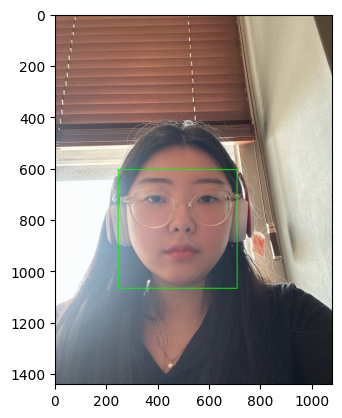

In [ ]:
dlib_rects, img = face_detect(os.path.join(data_path,'face.jpg'))

# 2. 랜드마크

In [ ]:
# dlib모델의 weight 다운로드 후 디렉토리 이동
! wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
! mv shape_predictor_68_face_landmarks.dat.bz2 "/content/drive/MyDrive/Colab Notebooks/AIFFEL/QuestC/models/"

# 압축해제
! cd "/content/drive/MyDrive/Colab Notebooks/AIFFEL/QuestC" && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

# 압축해제한 모델 위치
model_path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL/QuestC/models/shape_predictor_68_face_landmarks.dat'

--2025-04-10 08:04:01--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-04-10 08:04:01--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  35.9MB/s    in 1.7s    

2025-04-10 08:04:03 (35.9 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

bzip2: Output file ./models/shape_predictor_68_face_landmarks.dat already exists.


In [ ]:
# 랜드마크 검출
def landmark_detect(model_path, dlib_rects, img):
    img_show = img.copy() #여기에 랜드마크 표시
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 모델 로드
    landmark_predictor = dlib.shape_predictor(model_path)

    # 검출
    list_landmarks = []

    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    if len(list_landmarks) == 0 or len(list_landmarks[0]) == 0:
        print("랜드마크 검출되지 않음")
        return

    # 렌드마크 표시
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img_show, point, 5, (0, 255, 255), -1)
    img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB) #bgr->rgb
    plt.imshow(img_show_rgb)
    plt.show()

    return list_landmarks

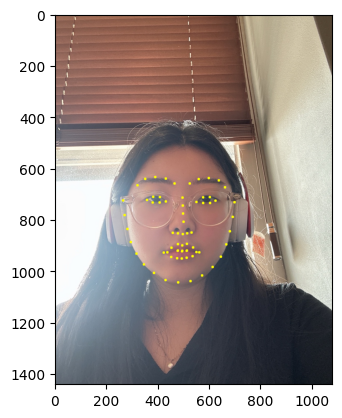

In [ ]:
landmarks = landmark_detect(model_path, dlib_rects, img)



---

# 3. 스티커 적용


In [ ]:
def cat_sticker_patch(img, sticker, landmarks, dlib_rects, sticker_weight=1):
    img_show = img.copy()
    try:
        for i, (dlib_rect, landmark) in enumerate(zip(dlib_rects, landmarks)):
            # x,y 좌표(center coordinates)
            x = landmark[33][0]
            y = (landmark[33][1] + landmark[30][1]) // 2
            print(f"[1] 얼굴 기준 좌표 (x, y): ({x}, {y})")

            # 스티커 크기는 얼굴 사이즈 기준
            face_width = dlib_rect.width()
            face_height = dlib_rect.height()
            w = int(face_width * 0.75)
            h = int(face_height * 0.50)
            print(f"[2] 스티커 크기 (w, h): ({w}, {h})")

            # 리사이즈
            resized_sticker = cv2.resize(sticker, (w, h))
            print(f"[3] 스티커 리사이즈 완료")

            # 눈 각도 계산 - 이 각도를 기준으로 스티커 회전할 예정
            dx = landmark[45][0] - landmark[36][0]
            dy = landmark[45][1] - landmark[36][1]
            angle = -np.degrees(np.arctan2(dy, dx))
            print(f"[4] 눈 각도(angle): {angle:.2f}°")

            # 스티커 회전. rotation mat 구하고 affine transform 함수로
            center = (w // 2, h // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            rotated_sticker = cv2.warpAffine(resized_sticker, rotation_matrix, (w, h),
                                            flags=cv2.INTER_LINEAR,
                                            borderMode=cv2.BORDER_CONSTANT,
                                            borderValue=(0, 0, 0, 0))
            print(f"[5] 회전된 스티커 shape: {rotated_sticker.shape}")

            # 붙일 위치 계산
            refined_x = x - w // 2
            refined_y = y - h // 2
            print(f"[6] 붙일 좌표 (refined_x, refined_y): ({refined_x}, {refined_y})")

            # 스티커가 이미지 밖으로도 나가는 경우
            # 스티커에서 잘라내야 할 offset을 먼저 계산함.
            offset_x = max(0, -refined_x)
            offset_y = max(0, -refined_y)
            refined_x = max(0, refined_x)
            refined_y = max(0, refined_y)

            # 붙일 수 있는 부분
            paste_w = min(w - offset_x, img.shape[1] - refined_x)
            paste_h = min(h - offset_y, img.shape[0] - refined_y)

            # 붙일 수 있는 부분이 없다면
            if paste_w <= 0 or paste_h <= 0:
                print("스티커가 아예 이미지 밖으로 나감")
                continue

            # 필요한 부분만 crop
            sticker_crop = rotated_sticker[offset_y:offset_y + paste_h, offset_x:offset_x + paste_w]

            # ch4 정보 이용해서 마스크 생성
            bgr_sticker = sticker_crop[..., :3]
            alpha_mask = sticker_crop[..., 3] > 0 # True 값만 사용
            mask = np.stack([alpha_mask] * 3, axis=-1)
            print(f"[7] 마스크 shape: {mask.shape}")

            # 원본에서 해당 영역 가져오기
            sticker_area = img_show[refined_y:refined_y + paste_h, refined_x:refined_x + paste_w]

            # blending
            blended = cv2.addWeighted(bgr_sticker, sticker_weight, sticker_area, 1 - sticker_weight, 0)
            sticker_area[mask] = blended[mask] #마스크값이 True인 부분만 쓴다

            # 반영
            img_show[refined_y:refined_y + paste_h, refined_x:refined_x + paste_w] = sticker_area

            # 스티커 출력
            plt.figure(figsize=(4, 3))
            plt.imshow(cv2.cvtColor(rotated_sticker, cv2.COLOR_BGRA2RGBA))
            plt.title(f"Rotated Sticker {i+1}")
            plt.axis('off')
            plt.show()

        # 최종 결과
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
        plt.title("Result")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"오류 발생: {e}")

In [ ]:
cat_sticker = cv2.imread(os.path.join(data_path, 'cat-whiskers.png'), cv2.IMREAD_UNCHANGED)
cat_sticker.shape
# cv2.IMREAD_UNCHANGED 로 읽어와야 투명도 반영 가능(배경 투명)

(512, 512, 4)

[1] 얼굴 기준 좌표 (x, y): (496, 832)
[2] 스티커 크기 (w, h): (347, 231)
[3] 스티커 리사이즈 완료
[4] 눈 각도(angle): -0.65°
[5] 회전된 스티커 shape: (231, 347, 4)
[6] 붙일 좌표 (refined_x, refined_y): (323, 717)
[7] 마스크 shape: (231, 347, 3)


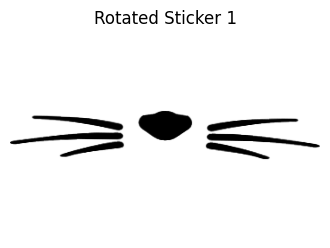

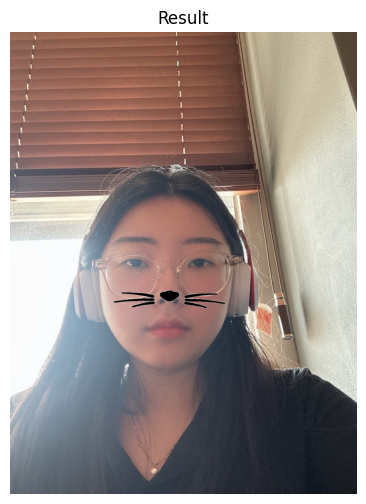

In [ ]:
cat_sticker_patch(img, cat_sticker, landmarks, dlib_rects)

# 4. 스티커 적용하기

In [ ]:
def king_sticker_patch(img, sticker, landmarks, dlib_rects, sticker_weight=1):
    img_show = img.copy()
    try:
        for i, (dlib_rect, landmark) in enumerate(zip(dlib_rects, landmarks)):
            x = landmark[30][0] # 이미지에서 코 부위의 x값
            y = landmark[30][1] - dlib_rect.height()//2
            print(f"[1] 얼굴 기준 좌표 (x, y): ({x}, {y})")

            face_width = dlib_rect.width()
            face_height = dlib_rect.height()
            w = h = dlib_rect.width()
            print(f"[2] 스티커 크기 (w, h): ({w}, {h})")

            resized_sticker = cv2.resize(sticker, (w, h))
            print(f"[3] 스티커 리사이즈 완료")

            # 눈 각도 계산 (roll)
            dx = landmark[45][0] - landmark[36][0]
            dy = landmark[45][1] - landmark[36][1]
            angle = -np.degrees(np.arctan2(dy, dx))
            print(f"[4] 눈 각도(angle): {angle:.2f}°")

            # 스티커 회전
            center = (w // 2, h // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            rotated_sticker = cv2.warpAffine(resized_sticker, rotation_matrix, (w, h))
            print(f"[5] 회전된 스티커 shape: {rotated_sticker.shape}")

            # 붙일 위치 계산
            refined_x = x - w // 2
            refined_y = y - h
            print(f"[6] 붙일 좌표 (refined_x, refined_y): ({refined_x}, {refined_y})")

            # 이미지 경계 보정
            # 스티커에서 잘라내야 할 offset을 먼저 계산함.
            offset_x = max(0, -refined_x)
            offset_y = max(0, -refined_y)
            refined_x = max(0, refined_x)
            refined_y = max(0, refined_y)

            # 붙일 수 있는 부분
            paste_w = min(w - offset_x, img.shape[1] - refined_x)
            paste_h = min(h - offset_y, img.shape[0] - refined_y)

            if paste_w <= 0 or paste_h <= 0:
                print("스티커가 아예 이미지 밖으로 나감")
                continue

            # 필요한 부분만 crop
            sticker_crop = rotated_sticker[offset_y:offset_y + paste_h, offset_x:offset_x + paste_w]

            # ch4 정보 이용해서 마스크 생성
            bgr_sticker = sticker_crop[..., :3]
            alpha_mask = sticker_crop[..., 3] > 0
            mask = np.stack([alpha_mask] * 3, axis=-1)
            print(f"[7] 마스크 shape: {mask.shape}")

            # 원본에서 해당 영역 가져오기
            sticker_area = img_show[refined_y:refined_y + paste_h, refined_x:refined_x + paste_w]

            # blending
            blended = cv2.addWeighted(bgr_sticker, sticker_weight, sticker_area, 1 - sticker_weight, 0)
            sticker_area[mask] = blended[mask]

            # 반영
            img_show[refined_y:refined_y + paste_h, refined_x:refined_x + paste_w] = sticker_area

            # 스티커 출력
            plt.figure(figsize=(4, 3))
            plt.imshow(cv2.cvtColor(rotated_sticker, cv2.COLOR_BGRA2RGBA))
            plt.title(f"Rotated Sticker {i+1}")
            plt.axis('off')
            plt.show()

        # 최종 결과
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
        plt.title("Result")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"오류 발생: {e}")

Box pixel:rectangles[[(345, 98) (531, 284)]]


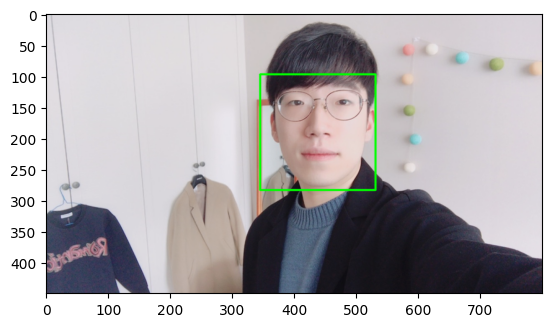

In [ ]:
dlib_rects, img = face_detect(os.path.join(data_path,'image.png'))

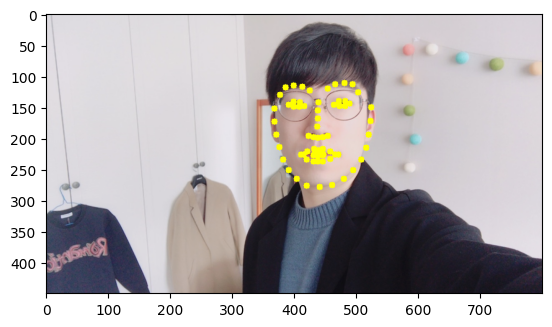

In [ ]:
landmarks = landmark_detect(model_path, dlib_rects, img)

In [ ]:
king_sticker = cv2.imread(os.path.join(data_path, 'king.png'),cv2.IMREAD_UNCHANGED)
king_sticker.shape

(512, 512, 4)

[1] 얼굴 기준 좌표 (x, y): (437, 89)
[2] 스티커 크기 (w, h): (187, 187)
[3] 스티커 리사이즈 완료
[4] 눈 각도(angle): 1.17°
[5] 회전된 스티커 shape: (187, 187, 4)
[6] 붙일 좌표 (refined_x, refined_y): (344, -98)
[7] 마스크 shape: (89, 187, 3)


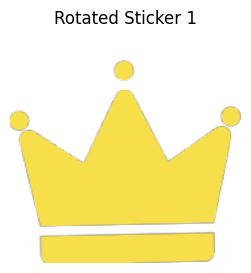

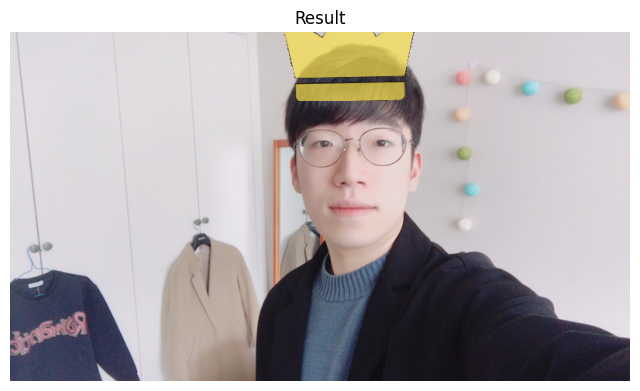

In [ ]:
king_sticker_patch(img, king_sticker, landmarks, dlib_rects, sticker_weight=0.7)

# 5. 문제점

- 얼굴 각도 돌렸을 때
    - 아예 인식 안되거나
    - 스티커만 똑바로 붙어있거나
- 해결: 눈 사이의 각도 계산 후 스티커 각도 돌림


얼굴 검출되지 않음


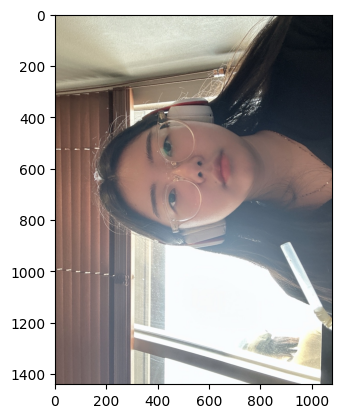

In [ ]:
# 1. 이미지 90도 rotate된 경우

# 얼굴 detect 아예 안됨
dlib_rects_90, img_90 = face_detect(os.path.join(data_path,'face_rotate90.jpg'))

Box pixel:rectangles[[(297, 451) (759, 913)]]


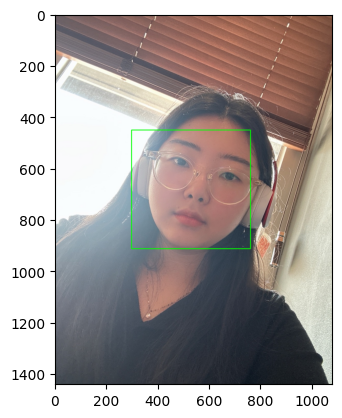

In [ ]:
# 2. 얼굴 각도
# 얼굴 detect 됨
dlib_rects_30, img_30 = face_detect(os.path.join(data_path,'face_rotate30.jpg'))

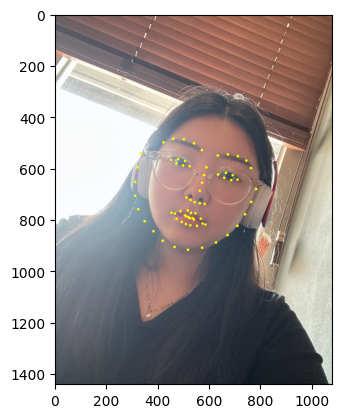

In [ ]:
landmarks_30 = landmark_detect(model_path, dlib_rects_30, img_30)

[1] 얼굴 기준 좌표 (x, y): (542, 709)
[2] 스티커 크기 (w, h): (347, 231)
[3] 스티커 리사이즈 완료
[4] 눈 각도(angle): -16.56°
[5] 회전된 스티커 shape: (231, 347, 4)
[6] 붙일 좌표 (refined_x, refined_y): (369, 594)
[7] 마스크 shape: (231, 347, 3)


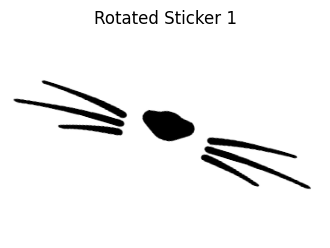

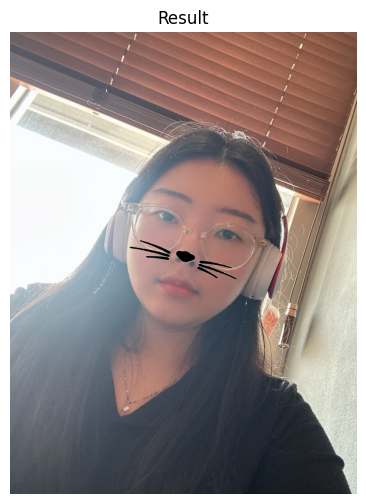

In [ ]:
# 스티커가 얼굴따라서 돌아갈 수 있도록 수정한 결과
cat_sticker_patch(img_30, cat_sticker, landmarks_30, dlib_rects_30)